[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/ensemble_demo.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/ensemble_demo.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow matplotlib

------------------
## Flow ensemble demo

This notebook demonstrates building a deep ensemble of normalizing flows with PZFlow.
A deep ensemble instantiates multiple Flows with different randomized initial parameters, and trains them on the same data.
This ensemble of trained flows accounts for epistemic uncertainty, and is a form of approximate Bayesian machine learning.

In [1]:
from pzflow import FlowEnsemble
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.facecolor"] = "white"

Let's load the two moons data set:

In [3]:
data = get_twomoons_data()
data

,x,y
0,-0.748695,0.777733
1,1.690101,-0.207291
2,2.008558,0.285932
3,1.291547,-0.441167
4,0.808686,-0.481017
...,...,...
99995,1.642738,-0.221286
99996,0.981221,0.327815
99997,0.990856,0.182546
99998,-0.343144,0.877573


Let's plot it to see what it looks like.

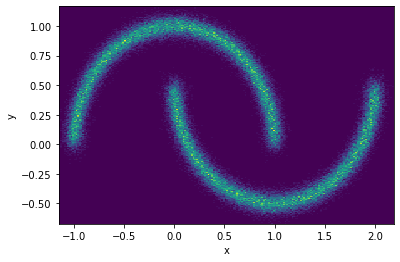

In [4]:
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we will build an ensemble of normalizing flows using the `FlowEnsemble` class.
It is constructed identically to `Flow`, except now we also have a parameter `N` which controls how many different copies of the Flow are created.
Each of these Flows is identical, just with different random parameters instantiated.
Let's make an ensemble of 4 Flows.

In [5]:
flowEns = FlowEnsemble(data.columns, N=4)

Now we can train the Ensemble.
Just like a refular `Flow`, this is as simple as calling `flowEns.train(data)`.

In [6]:
%%time
losses = flowEns.train(data, verbose=True)

Flow 0
Training 50 epochs 
Loss:
(0) 2.3370
(1) 0.7259
(3) 0.4162
(5) 0.3592
(7) 0.3221
(9) 0.3759
(11) 0.3107
(13) 0.3167
(15) 0.3075
(17) 0.3274
(19) 0.3528
(21) 0.3151
(23) 0.3165
(25) 0.3040
(27) 0.3033
(29) 0.3080
(31) 0.3027
(33) 0.3136
(35) 0.3066
(37) 0.3024
(39) 0.3243
(41) 0.3022
(43) 0.3095
(45) 0.3059
(47) 0.3004
(49) 0.2994
(50) 0.2967
Flow 1
Training 50 epochs 
Loss:
(0) 2.3284
(1) 0.7375
(3) 0.3661
(5) 0.3464
(7) 0.3462
(9) 0.3234
(11) 0.3281
(13) 0.3144
(15) 0.3145
(17) 0.3101
(19) 0.3084
(21) 0.3180
(23) 0.3074
(25) 0.3131
(27) 0.3110
(29) 0.3013
(31) 0.3059
(33) 0.3105
(35) 0.3047
(37) 0.3038
(39) 0.3097
(41) 0.3102
(43) 0.3028
(45) 0.3023
(47) 0.2999
(49) 0.3092
(50) 0.3024
Flow 2
Training 50 epochs 
Loss:
(0) 2.3538
(1) 0.7529
(3) 0.3626
(5) 0.3337
(7) 0.3332
(9) 0.3190
(11) 0.3107
(13) 0.3072
(15) 0.3155
(17) 0.3028
(19) 0.3102
(21) 0.3037
(23) 0.3286
(25) 0.3076
(27) 0.3027
(29) 0.3105
(31) 0.3024
(33) 0.3078
(35) 0.3043
(37) 0.3030
(39) 0.3021
(41) 0.3017
(43) 0.

The losses returned by a `FlowEnsemble` are saved in a dictionary. Let's plot them.

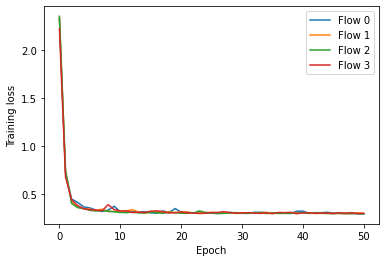

In [7]:
for n, l in losses.items():
    plt.plot(l, label=n)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the ensemble, using the `sample` method.
Let's draw 10000 samples and make another histogram to see if it matches the data.

In [8]:
samples = flowEns.sample(10000, seed=0)

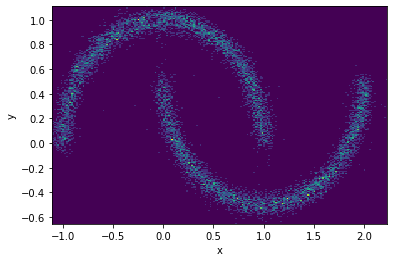

In [9]:
plt.hist2d(samples['x'], samples['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Looks great!

Note that when sampling from the ensemble, it will draw uniformly from the constituent flows in the ensemble.
So, e.g., if your ensemble has 4 flows and you ask for 16 samples, it will draw 4 sample from each of the 4 flows in the sample.
The process is slightly different if the number of flows doesn't evenly divide the number of samples.
If you have 4 flows and ask for 17 samples, it will draw 5 samples from each flow, so that you now have 20 samples, and then it will randomly select 17 of those.

There is also one more important feature to note.
In the `sample` method, if you set `returnEnsemble=True`, then it will sample `nsamples` from each flow, and then will return all of those samples, sorted by the flow they came from.
This allows you to e.g. compare samples from each of the constituent flows and see if they're consistent with one another.

Let's draw 4 samples from each flow and print them so we can get an idea of how this works:

In [10]:
flowEns.sample(4, seed=0, returnEnsemble=True)

x         y
Flow 0 0  0.153830  0.084099
       1  0.036924  1.021060
       2 -0.215726  1.051067
       3 -0.223551  0.964875
Flow 1 0  0.137350  0.013202
       1  0.141463  1.031508
       2 -0.247361  1.053012
       3 -0.209796  0.986897
Flow 2 0  0.185029  0.064171
       1 -0.129488  1.030470
       2 -0.432348  0.987865
       3 -0.419133  0.906174
Flow 3 0  0.087466  0.151030
       1  0.047206  1.040986
       2 -0.293748  1.041880
       3 -0.255163  0.969795

We can also use the ensemble to calculate redshift posteriors using the `posterior` method. This works by calculating the unnormalized posterior for each constituent flow, averaging over them all, then normalizing. (Note we can do the same thing with the `log_prob` method)

In [11]:
grid = jnp.linspace(-2, 2, 100)
pdfs = flowEns.posterior(data[:100], column="x", grid=grid)

Let's plot the first posterior.

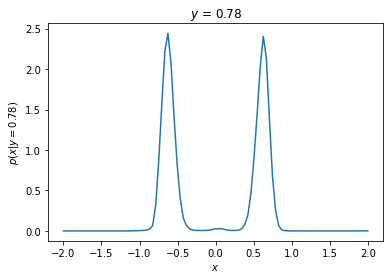

In [12]:
plt.plot(grid, pdfs[0])
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y=0.78)$")
plt.show()

Similarly to the `sample` method, we can set `returnEnsemble=True` to return the pdfs for each of the constituent flows.

In [13]:
ensemble_pdfs = flowEns.posterior(data[:100], column="x", grid=grid, returnEnsemble=True)

the returned array has shape (nsamples, nflows, grid.size):

In [14]:
ensemble_pdfs.shape

(100, 4, 100)

Let's plot all the pdfs from the ensemble for the first galaxy:

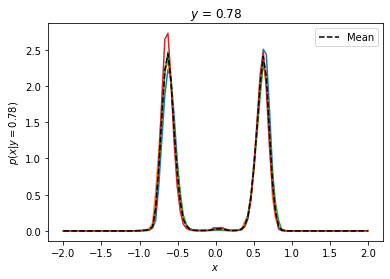

In [15]:
for i in range(ensemble_pdfs.shape[1]):
    plt.plot(grid, ensemble_pdfs[0,i])
plt.plot(grid, pdfs[0], ls="--", c="k", label="Mean")
plt.legend()
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y=0.78)$")
plt.show()

Now let's save the ensemble to a file that can be loaded later:

In [18]:
flowEns.save("example-ensemble.pzflow.pkl")

This file can be loaded on Flow instantiation:

In [19]:
flowEns = FlowEnsemble(file="example-ensemble.pzflow.pkl")